In [1]:
import win32com.client
from datetime import date
import numpy as np
import time
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import visa # provides generic usb interface to the powermeter
from ThorlabsPM100 import ThorlabsPM100 # actually knows how to talk to the powermeter
%matplotlib notebook

In [2]:
class DigitalPowerMeasurer:
    """
    This class takes analog devices on an AI card, a usb connection to the power meters, 
    a PrairieLink, and xmls and gpls to definethe SLM experiment.
    It then fires the experiment once to find the best power range, 
    initializes the analog devices, starts the SLM experiments and listens to the analog inputs.
    returns a power range array and the analog input array."""
    
    def __init__(self,prairie_link, visa_resource_manager, power_meter_list):
        
        # store configruation
        self.pl = prairie_link
        self.rm = visa_resource_manager
        self.num_power_meters = len(power_meter_list)
        
        # create power_meters
        self.instruments = []
        self.power_meters = []
        for i in range(self.num_power_meters):
            self.instruments.append(rm.open_resource(power_meter_list[i]))
            self.power_meters.append(ThorlabsPM100(inst=self.instruments[i]))
        
    def measure(self,laser_name,wavelength,laser_power,window_length=5):
        """
        laser name needs to match a laser name in PrairieView
        Wavelength needs to be accessible trhough the PrairieView 2P laser tab
        take {laser_name:laser_power[PV]} dictionary and perform measurement with this power for 3s"""
        
        voltage_array = np.zeros(self.num_power_meters)
        
        pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(laser_power))
        time.sleep(window_length)
        
        for i in range(self.num_power_meters):
            # set the power meter wavelength
            self.power_meters[i].sense.correction.wavelength = wavelength
            
            # use USB correction to measure current power
            voltage_array[i] = self.power_meters[i].read
        
        pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(0))
        
        return voltage_array

In [3]:
def pockel_curve(x,I,k,phi):
    return I * np.cos(k*x + phi)**2

def arctangent(x, phi, I_0, I, k):
    return I * np.arctan(k*(x + phi)) + I_0

In [4]:
# Start PrairieLink
pl = win32com.client.Dispatch('PrairieLink.Application')
print('object created')

# Connect to Client
pl.Connect()
print(pl.Connected)

object created
<bound method Connected of <COMObject PrairieLink.Application>>


In [5]:
# Search for PowerMeters
rm=visa.ResourceManager()
resource_list = rm.list_resources()
print(resource_list)

# create powermeter, assume that it is the first object showing up in the above list
pm100 = DigitalPowerMeasurer(pl,rm,[resource_list[0]])

('USB0::0x1313::0x8079::P1003280::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL6::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR', 'ASRL10::INSTR', 'ASRL13::INSTR')


# MAKE sure you:
## open laser shutters
## center galvos
## check if you are in resonant galvo mode
## check PMT shutters are closed
## think about SLM if using uncaging

In [7]:
laser_name = 'Imaging'
wavelength = 920

pl.SendScriptCommands('-SetMultiPhotonWavelength' + ' ' + str(wavelength) + ' ' + str(1))
# Allow Chameleon to change its colours
time.sleep(15)

powerspace = np.arange(0,1050,50)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    voltage_array[i] = pm100.measure('Imaging', wavelength, powerspace[i],3)
    time.sleep(3)
    print(voltage_array[i])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.00193363277
0.00461137015
0.0163637623
0.0392733328
0.063224256
0.0928282589
0.133886963
0.17375569
0.217343405
0.257955879
0.301989913
0.337544441
0.373842776
0.399876326
0.422785878
0.438554883
0.443612933
0.439001203
0.427843928
0.408802181
0.386785239


## create good folder and put it into the script below

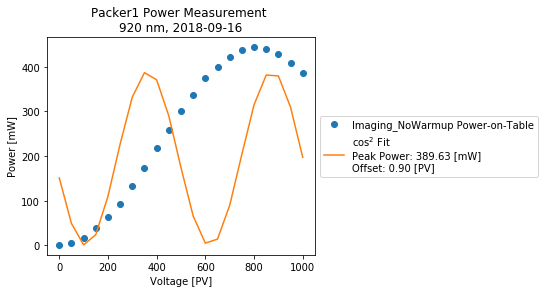

In [8]:
laser_name = 'Imaging_NoWarmup'
wavelength = 920

datestring = date.today().isoformat()

powerspace = np.arange(0,1050,50)

guess = (0.14,1/500,1)
popt, pcov = curve_fit(pockel_curve,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*pockel_curve(powerspace,*popt),label=r"cos$^{2}$ Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format(popt[0]*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[2]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

folder = r"F:\Data\mloidolt\2018-09-16\2018-09-16_PowerMeasurements"

os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

In [9]:
laser_name = 'Imaging'
wavelength = 765

pl.SendScriptCommands('-SetMultiPhotonWavelength' + ' ' + str(wavelength) + ' ' + str(1))
# Allow Chameleon to change its colours
time.sleep(15)

powerspace = np.arange(0,1050,50)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    voltage_array[i] = pm100.measure('Imaging', wavelength, powerspace[i],3)
    print(voltage_array[i])
    time.sleep(3)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.00367284333
0.0224791877
0.0609733909
0.119743131
0.189826041
0.26975292
0.360552162
0.45179227
0.532600701
0.606944442
0.671591103
0.720810831
0.75122416
0.761949599
0.752693474
0.721986175
0.677761972
0.611058354
0.540681422
0.453702182
0.381415546


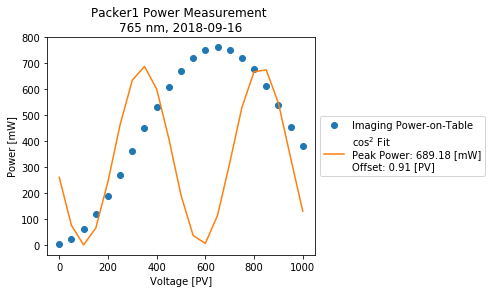

In [10]:
powerspace = np.arange(0,1050,50)
laser_name = 'Imaging'
wavelength = 765

guess = (0.14,1/500,1)
popt, pcov = curve_fit(pockel_curve,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*pockel_curve(powerspace,*popt),label=r"cos$^{2}$ Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format(popt[0]*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[2]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

# be very careful to go above 800 PV if using uncaging path 
# Pmax = 5W for the thermosensor
# be even MORE careful if using the wand Pmax = 0.5W

In [12]:
laser_name = 'Uncaging'
wavelength=1030

powerspace = np.arange(200,830,30)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    print(powerspace[i])
    voltage_array[i] = pm100.measure(laser_name, wavelength, powerspace[i],3)
    print(voltage_array[i])
    time.sleep(10)

200


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


-0.00135430507
230
0.00120327307
260
0.00376094179
290
0.0138409473
320
0.0299389493
350
0.0523558334
380
0.0899679661
410
0.127279222
440
0.174369678
470
0.236805782
500
0.306162655
530
0.380333751
560
0.460071504
590
0.536048114
620
0.611422777
650
0.694620848
680
0.746375144
710
0.814377964
740
0.852140486
770
0.877115011
800
0.886894166


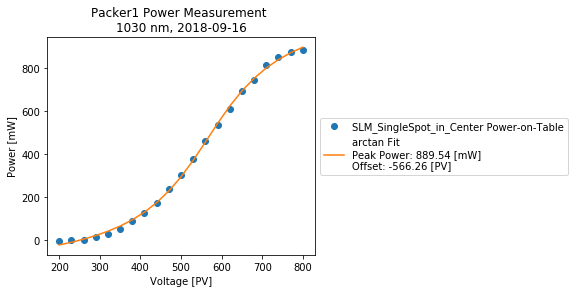

In [13]:
folder = r"F:\Data\mloidolt\2018-09-16\2018-09-16_PowerMeasurements"


datestring = date.today().isoformat()

laser_name = 'SLM_SingleSpot_in_Center'
wavelength=1030

powerspace = np.arange(200,830,30)
guess = (-700,500,300,0.02)
popt, pcov = curve_fit(arctangent,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*arctangent(powerspace,*popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

In [47]:
laser_name = 'Uncaging'
wavelength=1030

powerspace = np.arange(200,1025,25)

len_powerspace = len(powerspace)

voltage_array = np.zeros((len_powerspace,2))

for i in range(len_powerspace):
    print(powerspace[i])
    voltage_array[i] = pm100.measure(laser_name, wavelength, powerspace[i],5)
    print(voltage_array[i])
    time.sleep(10)

200


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


[0.0004511  0.00020337]
225
[0.00255731 0.00020337]
250
[ 0.00676989 -0.00060819]
275
[0.01534547 0.00081204]
300
[ 0.0349038  -0.00020241]
325
[6.22854382e-02 4.76715002e-07]
350
[0.10034895 0.00020337]
375
[ 0.15150142 -0.00020241]
400
[0.21514116 0.0014208 ]
425
[0.28961328 0.00040626]
450
[ 0.38123643 -0.00101397]
475
[4.85046059e-01 4.06256528e-04]
500
[ 0.60089135 -0.00121696]
525
[ 0.73193204 -0.00121696]
550
[ 8.72150242e-01 -6.08192990e-04]
575
[1.02560782e+00 4.06256528e-04]
600
[ 1.18598592e+00 -1.01397280e-03]
625
[1.36186039e+00 6.09146431e-04]
650
[ 1.54465544e+00 -6.08192990e-04]
675
[1.72459209e+00 6.09146431e-04]
700
[1.91340470e+00 6.09146431e-04]
725
[ 2.09800529e+00 -1.41984795e-03]
750
[2.28561473e+00 4.76715002e-07]
775
[ 2.46720600e+00 -4.05303086e-04]
800
[ 2.63510656e+00 -4.05303086e-04]
825
[2.80932641e+00 4.76715002e-07]
850
[2.96293426e+00 2.03366624e-04]
875
[ 3.10525846e+00 -2.02413183e-04]
900
[ 3.23705149e+00 -1.41984795e-03]
925
[ 3.35379958e+00 -4.0530

<IPython.core.display.Javascript object>


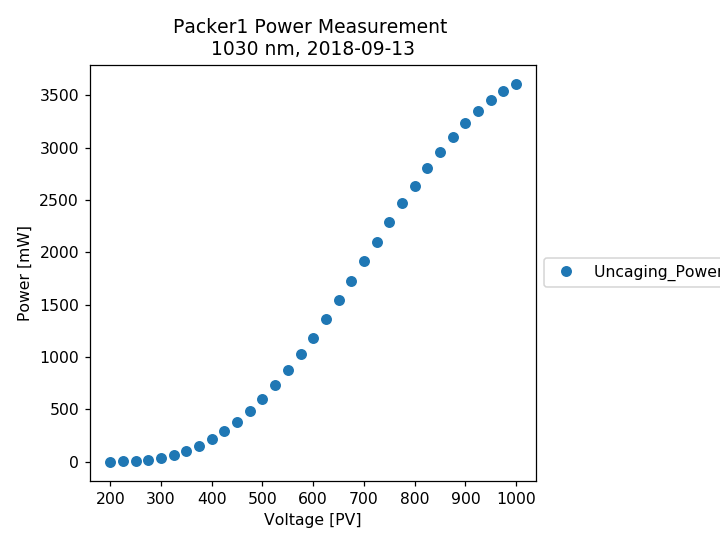

<IPython.core.display.Javascript object>


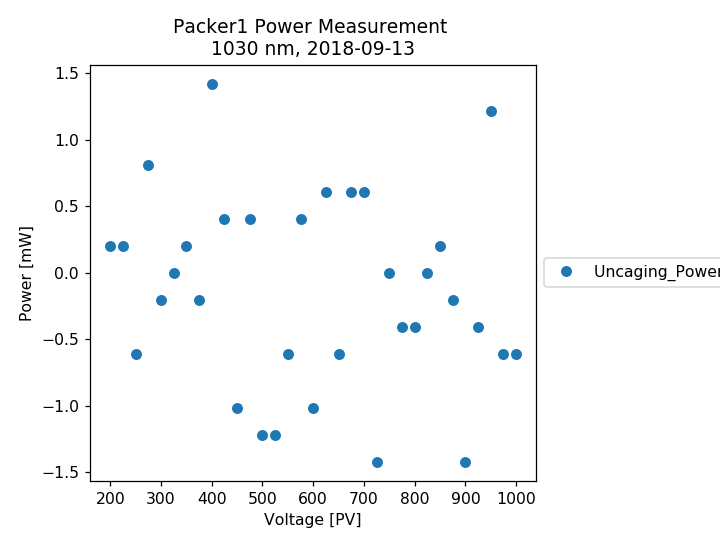

In [50]:
for i in range(2):
    folder = r"F:\Data\mloidolt\2018-09-13\2018-09-13_PowerMeasurements"


    datestring = date.today().isoformat()

    laser_name = 'Uncaging_PowerOnTable_oneFifth' + str(i)
    wavelength=1030

    powerspace = np.arange(200,1025,25)
    guess = (-700,500,300,0.02)
    #popt, pcov = curve_fit(arctangent,powerspace,voltage_array[:,i],guess)

    fig = plt.figure()
    ax = plt.subplot(111)

    ax.plot(powerspace,1000*voltage_array[:,i],linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
    #ax.plot(powerspace,1000*arctangent(powerspace,*popt),label=r"arctan Fit" + "\n"
    #         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
    #         "Offset: {:.2f} [PV]".format(popt[0]))

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Voltage [PV]")
    plt.ylabel("Power [mW]")
    plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)

    # construct Packer-xkcd-compliant datestring
    datestring = date.today().isoformat()
    operator = "mloidolt"

    os.chdir(folder)
    plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
    np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
    np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array'+str(i),voltage_array[:,i])
    #np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt'+str(i),popt)
    #np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov'+str(i),pcov)

# make sure and double check if SLM is actually in position before going above PV=800

In [64]:
laser_name = 'Uncaging'
wavelength=1030

powerspace = np.arange(200,725,25)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    print(powerspace[i])
    voltage_array[i] = pm100.measure(laser_name, wavelength, powerspace[i],5)
    print(voltage_array[i])
    time.sleep(10)

200


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.000906735717
225
0.00166243932
250
0.00604526699
275
0.0113349212
300
0.0190426279
325
0.0337024257
350
0.0550120734
375
0.0840294287
400
0.119243264
425
0.16201368
450
0.211887315
475
0.265085816
500
0.329014778
525
0.402464986
550
0.470172256
575
0.549365401
600
0.61843282
625
0.694754601
650
0.759590387
675
0.819740951
700
0.91404748


<IPython.core.display.Javascript object>


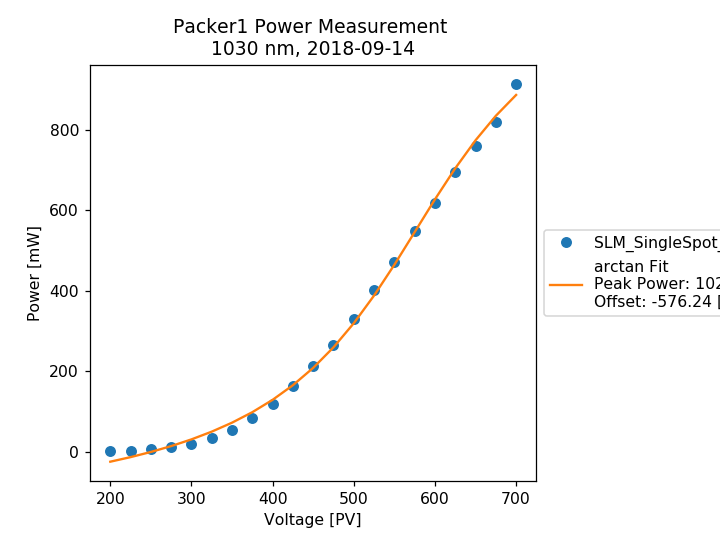

In [65]:
folder = r"F:\Data\mloidolt\2018-09-13\2018-09-13_PowerMeasurements"

datestring = date.today().isoformat()

laser_name = 'SLM_SingleSpot_in_Center'
wavelength=1030

powerspace = np.arange(200,725,25)
guess = (-700,500,300,0.02)
popt, pcov = curve_fit(arctangent,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*arctangent(powerspace,*popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

In [10]:
PV = np.arange(300,700,50)
print(PV)
I = np.asarray([0.04,0.124,0.277,0.494,0.772,1.117,1.532,1.911])
Y = I/2 * 680
print(Y)

[300 350 400 450 500 550 600 650]
[ 13.6   42.16  94.18 167.96 262.48 379.78 520.88 649.74]


[-5.82438089e+02  4.71591407e+02  4.31698122e+02  6.47443366e-03]
[-7.e+02  5.e+02  3.e+02  2.e-02]


<IPython.core.display.Javascript object>


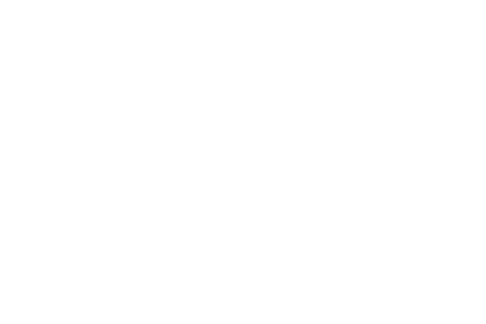

Text(0.5,1,'Packer1 Power Measurement \n1030 nm, 2018-09-07')

<IPython.core.display.Javascript object>


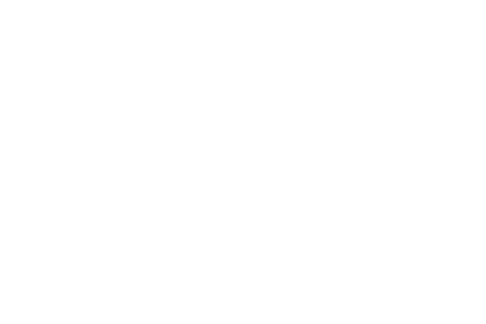

In [9]:
folder = r"F:\Data\mloidolt\2018-09-05\2018-09-05_PowerMeasurements"
os.chdir(folder)

datestring = date.today().isoformat()

laser_name = 'Uncaging'
wavelength=1030

powerspace = np.load("2018-09-05_Uncaging_1030_powerspace.npy")
voltage_array = np.load("2018-09-05_Uncaging_1030_voltage_array.npy")
stable_popt = np.load("2018-09-05_Uncaging_1030_popt.npy")

Y = I/2 * 680
X = PV

old_popt = np.load(r"F:\Data\mloidolt\2018-08-23\2018-08-23_PowerMeasurements\2018-08-23_Uncaging_1030_popt.npy")
powerspace = np.arange(300,1000,30)

guess = (-700,500,300,0.02)

popt, pcov = curve_fit(arctangent,X,Y,guess)
print(popt)
print(old_popt)

fig = plt.figure()
ax = plt.subplot(111)

#plt.plot(powerspace,arctangent(powerspace,*old_popt)/multiplicator)
ax.plot(X,Y,linestyle='None',marker='o',color='blue',label=laser_name + ' Peak Power')
ax.plot(powerspace,arctangent(powerspace,*popt),color='blue',label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))
ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power afer 5s',color='green')
ax.plot(powerspace,1000*arctangent(powerspace,*stable_popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(old_popt[0]),color='green')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)